# About Dataset

link https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/data


Medical data is extremely hard to find due to HIPAA privacy regulations. This dataset offers a solution by providing medical transcription samples.

## Imports

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
import kagglehub
import os

## Load The Data

In [3]:
# Download latest version
path = kagglehub.dataset_download("tboyle10/medicaltranscriptions")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'medicaltranscriptions' dataset.
Path to dataset files: /kaggle/input/medicaltranscriptions


In [4]:
print(os.listdir(path))

['mtsamples.csv']


In [5]:
df = pd.read_csv(os.path.join(path,'mtsamples.csv'))

## Explore The Data

In [6]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [7]:
df.isnull().sum()

,0
Unnamed: 0,0
description,0
medical_specialty,0
sample_name,0
transcription,33
keywords,1068


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.shape

(4999, 6)

## Preprocessing

In [10]:
# Droping nans
df = df.dropna().reset_index(drop=True)

In [11]:
# A fuc^n to get unique words(vocabulary) and sentence count in a list of text

def get_sentence(text):
  sen_count = 0
  word_count = 0
  vocab = {}
  set_count = 0 # Initialize set_count
  for i in text:                                  # Iterates through every text element in the input list.
    sentences =  sent_tokenize(str(i).lower())    # Uses sent_tokenize (from nltk.tokenize) to split text into individual sentences.
    set_count +=  len(sentences)                  # Counts how many sentences are in this text and adds to the running total.
    for sentence in sentences:
      words = word_tokenize(sentence)             # Splits each sentence into tokens (words/punctuation) using word_tokenize.
      for word in words:
        if (word in vocab.keys()):                # if it already exists in vocab, increment its count. Otherwise, add it with a count of 1.
          vocab[word] +=  1
        else:
          vocab[word] = 1

    word_count = len(vocab.keys())                # Counts how many unique words were found in total (not the total tokens).
    return sen_count,word_count                   # Returns a tuple:

In [12]:
sent_count,word_count= get_sentence(df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = df.groupby(df['medical_specialty'])
i = 1
print('Original Categories')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1


Number of sentences in transcriptions column: 0
Number of unique words in transcriptions column: 138
Original Categories
Cat:1  Allergy / Immunology : 3
Cat:2  Bariatrics : 18
Cat:3  Cardiovascular / Pulmonary : 280
Cat:4  Chiropractic : 4
Cat:5  Consult - History and Phy. : 234
Cat:6  Cosmetic / Plastic Surgery : 25
Cat:7  Dentistry : 25
Cat:8  Dermatology : 25
Cat:9  Diets and Nutritions : 10
Cat:10  Discharge Summary : 77
Cat:11  ENT - Otolaryngology : 84
Cat:12  Emergency Room Reports : 31
Cat:13  Endocrinology : 15
Cat:14  Gastroenterology : 195
Cat:15  General Medicine : 146
Cat:16  Hematology - Oncology : 62
Cat:17  Hospice - Palliative Care : 5
Cat:18  IME-QME-Work Comp etc. : 4
Cat:19  Lab Medicine - Pathology : 8
Cat:20  Letters : 20
Cat:21  Nephrology : 63
Cat:22  Neurology : 168
Cat:23  Neurosurgery : 81
Cat:24  Obstetrics / Gynecology : 130
Cat:25  Office Notes : 44
Cat:26  Ophthalmology : 79
Cat:27  Orthopedic : 303
Cat:28  Pain Management : 58
Cat:29  Pediatrics - Neonat

In [13]:
# catgeories have less than 50 samples
# may be they are imp but it'll creat dataa imbalance

category_counts = df['medical_specialty'].value_counts()

# Categories with less than 50 samples
small_categories = category_counts[category_counts < 50]
print("Categories with less than 50 samples:")
print(small_categories)

Categories with less than 50 samples:
medical_specialty
Office Notes                  44
Pediatrics - Neonatal         42
Podiatry                      42
Emergency Room Reports        31
Dentistry                     25
Cosmetic / Plastic Surgery    25
Dermatology                   25
Letters                       20
Psychiatry / Psychology       19
Sleep Medicine                18
Bariatrics                    18
Endocrinology                 15
Physical Medicine - Rehab     11
Diets and Nutritions          10
Lab Medicine - Pathology       8
Speech - Language              8
Rheumatology                   7
Hospice - Palliative Care      5
IME-QME-Work Comp etc.         4
Chiropractic                   4
Allergy / Immunology           3
Name: count, dtype: int64


In [14]:
df_filtered = df[~df['medical_specialty'].isin(small_categories.index)]
df = df_filtered.reset_index(drop=True)

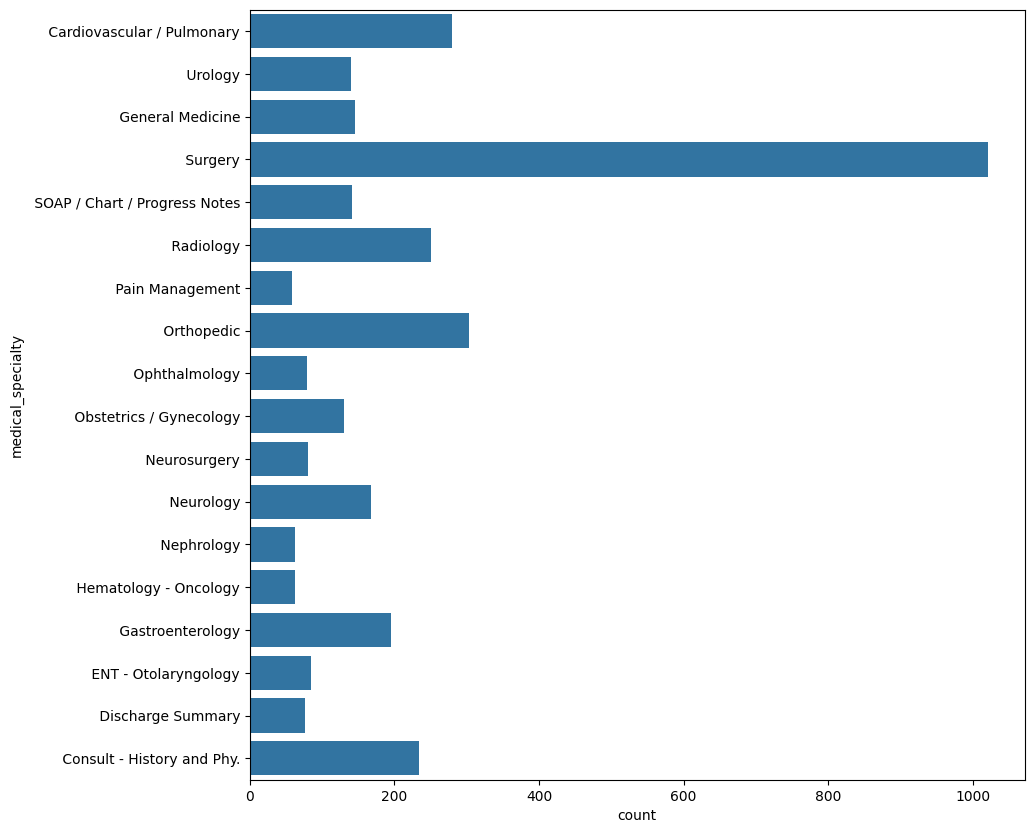

In [15]:

plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = df )
plt.show()

In [22]:
# sample text to see
df.iloc[1000]['transcription']

'preoperative diagnosis right carpal tunnel syndrome postoperative diagnosis right carpal tunnel syndrome title of the procedure right carpal tunnel release complication there were no complication during the procedure specimen the specimen wa sent to pathology instrument all count were correct at the end of the case and no complication were encountered indication this is a year old female who have been complaining of right hand pain which wa steadily getting worse over a prolonged period of time the patient had tried nonoperative therapy which did not assist the patient the patient had previous diagnosis of carpal tunnel and emg showed compression of the right median nerve a a result of these finding the patient wa sent to my office presenting with this history and wa carefully evaluated on initial evaluation the patient had the symptomology of carpal tunnel syndrome the patient at the time had the risk benefit and alternative thoroughly explained to her all question were answered no g

you can see there is  alot of different symbols and all let's clear that out

In [20]:
# fuc to clean text you can use this any to text it'll work on all

import re, string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Precompute once
_PUNC_TABLE = str.maketrans('', '', string.punctuation)
_REPLACE_BY_SPACE_RE = re.compile(r'[/(){}\[\]\|@,;]')

def clean_text(text, *, remove_digits=True, to_lower=True):
    """
    Remove punctuation/symbols and collapse whitespace.
    Keeps only letters/numbers/spaces (digits removable via flag).
    """
    s = '' if text is None else str(text)

    # normalize separators that often glue words
    s = s.replace('_', ' ').replace('-', ' ')

    if to_lower:
        s = s.lower()

    # strip standard punctuation
    s = s.translate(_PUNC_TABLE)

    # remove specific leftover symbols (belt-and-suspenders)
    s = _REPLACE_BY_SPACE_RE.sub(' ', s)

    # optionally drop digits
    if remove_digits:
        s = re.sub(r'\d+', ' ', s)

    # collapse whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    return s


def lemmatize_text(text):
    """
    Lemmatize the whole (already-cleaned) text.
    """
    if not isinstance(text, str):
        text = str(text)
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(lemmas)


def clean_and_lemmatize(text, *, remove_digits=True, to_lower=True):
    """
    One-shot pipeline: clean -> lemmatize.
    """
    return lemmatize_text(clean_text(text, remove_digits=remove_digits, to_lower=to_lower))


In [21]:
df['transcription'] = df['transcription'].apply(clean_text)
df['transcription'] = df['transcription'].apply(clean_and_lemmatize)


In [23]:
# TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=(1,3),
    max_df=0.75,
    use_idf=True,
    smooth_idf=True,
    max_features=1000
)

tfIdfMat = vectorizer.fit_transform(df['transcription'].tolist())

feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)


['abdomen', 'abdomen soft', 'abdomen wa', 'abdominal', 'able', 'abnormal', 'abnormality', 'abscess', 'achieved', 'active', 'activity', 'acute', 'addition', 'additional', 'adequate', 'adhesion', 'administered', 'admission', 'admitted', 'advanced', 'age', 'ago', 'air', 'alert', 'allergy', 'allowed', 'alternative', 'anastomosis', 'anesthesia', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia wa', 'anesthetic', 'angle', 'ankle', 'anterior', 'anterior chamber', 'anteriorly', 'antibiotic', 'aorta', 'aortic', 'appear', 'appearance', 'appeared', 'appearing', 'appears', 'appendix', 'applied', 'applied patient', 'appropriate', 'approximated', 'approximately', 'approximately cm', 'area', 'area wa', 'arm', 'artery', 'artery wa', 'aspect', 'aspiration', 'assessment', 'associated', 'atrial', 'attachment', 'attention', 'attention wa', 'attention wa directed', 'attention wa turned', 'awakened', 'away', 'baby', 'balloon', 'base', 'based', 'bed', 'began', 'benefit', 'betadine', 'bett

## Model

In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import numpy as np

# labels
labels = df['medical_specialty'].tolist()

# split BEFORE fitting SVD (no leakage)
X_train, X_test, y_train, y_test = train_test_split(
    tfIdfMat, labels, test_size=0.2, stratify=labels, random_state=1
)

# choose components: either fixed, or target ~95% variance
# Option A: fixed size (simple & robust)
svd = TruncatedSVD(n_components=300, random_state=1)
svd.fit(X_train)

# Optionally see how much variance 300 comps keep:
print("Variance @300 comps:", svd.explained_variance_ratio_.sum())

# transform
X_train_red = svd.transform(X_train)
X_test_red  = svd.transform(X_test)

# optional: L2-normalize (often good with SVD on text)
norm = Normalizer(copy=False)
X_train_red = norm.fit_transform(X_train_red)
X_test_red  = norm.transform(X_test_red)


Variance @300 comps: 0.8143894674640085


In [26]:
probe = TruncatedSVD(n_components=min(500, tfIdfMat.shape[1]-1), random_state=1)
probe.fit(X_train)
cum = np.cumsum(probe.explained_variance_ratio_)
k = int(np.searchsorted(cum, 0.95) + 1)
svd = TruncatedSVD(n_components=k, random_state=1).fit(X_train)
X_train_red = svd.transform(X_train)
X_test_red  = svd.transform(X_test)
X_train_red = Normalizer(copy=False).fit_transform(X_train_red)
X_test_red  = Normalizer(copy=False).transform(X_test_red)
print(f"Picked k={k}, variance={svd.explained_variance_ratio_.sum():.3f}")


Picked k=501, variance=0.933


In [27]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Linear SVM (with quick C search)
svm = LinearSVC(class_weight='balanced', random_state=1)
param_grid = {"C": [0.1, 0.3, 1.0, 3.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
svm_grid = GridSearchCV(svm, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=0)
svm_grid.fit(X_train_red, y_train)

best_svm = svm_grid.best_estimator_
print("Best SVM C:", svm_grid.best_params_["C"])

# Logistic Regression (baseline)
logreg = LogisticRegression(
    max_iter=2000, class_weight='balanced', solver='lbfgs', n_jobs=-1
)
logreg.fit(X_train_red, y_train)


Best SVM C: 0.1


LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [28]:
# SVM
y_pred_svm = best_svm.predict(X_test_red)
acc_svm = accuracy_score(y_test, y_pred_svm)
f1m_svm = f1_score(y_test, y_pred_svm, average='macro')
f1w_svm = f1_score(y_test, y_pred_svm, average='weighted')
print(f"[SVM] Acc={acc_svm:.4f} | F1-macro={f1m_svm:.4f} | F1-weighted={f1w_svm:.4f}")
print("\n[SVM] Per-class report:\n", classification_report(y_test, y_pred_svm))

# Logistic Regression
y_pred_lr = logreg.predict(X_test_red)
acc_lr = accuracy_score(y_test, y_pred_lr)
f1m_lr = f1_score(y_test, y_pred_lr, average='macro')
f1w_lr = f1_score(y_test, y_pred_lr, average='weighted')
print(f"[LogReg] Acc={acc_lr:.4f} | F1-macro={f1m_lr:.4f} | F1-weighted={f1w_lr:.4f}")
print("\n[LogReg] Per-class report:\n", classification_report(y_test, y_pred_lr))


[SVM] Acc=0.4054 | F1-macro=0.4444 | F1-weighted=0.3548

[SVM] Per-class report:
                                 precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.49      0.64      0.55        56
    Consult - History and Phy.       0.37      0.32      0.34        47
             Discharge Summary       0.41      0.87      0.55        15
          ENT - Otolaryngology       0.47      0.82      0.60        17
              Gastroenterology       0.49      0.56      0.52        39
              General Medicine       0.36      0.28      0.31        29
         Hematology - Oncology       0.21      0.42      0.28        12
                    Nephrology       0.33      0.69      0.45        13
                     Neurology       0.36      0.50      0.42        34
                  Neurosurgery       0.30      0.81      0.44        16
       Obstetrics / Gynecology       0.39      0.73      0.51        26
                 Ophthalmology       0.41      0.88  

## Results

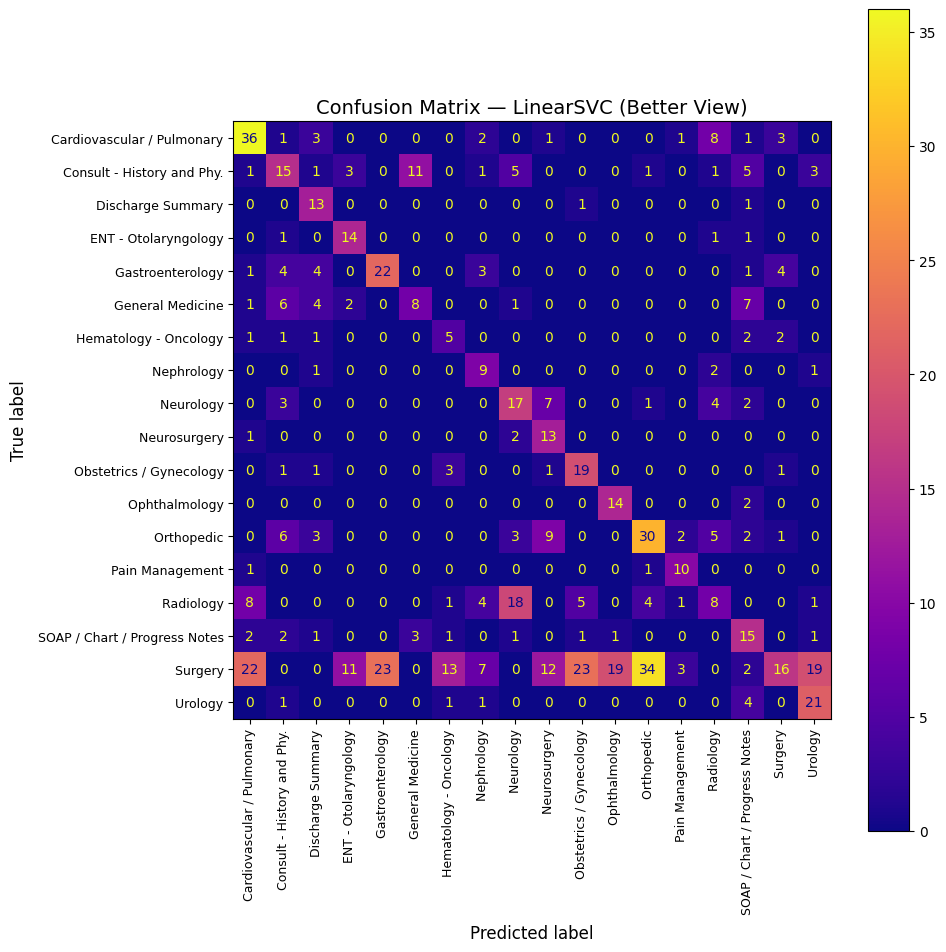

In [30]:
# pick the better of SVM vs LogReg by macro-F1
use_svm = f1m_svm >= f1m_lr
y_pred = y_pred_svm if use_svm else y_pred_lr
title = "LinearSVC" if use_svm else "LogReg"

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

# Plot with better aesthetics
fig, ax = plt.subplots(figsize=(10, 10))  # Bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    cmap="plasma",          # color map (try: 'Blues', 'viridis', 'magma', etc.)
    xticks_rotation=90,
    ax=ax,
    colorbar=True
)

# Adjust layout
plt.title("Confusion Matrix — LinearSVC (Better View)", fontsize=14)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

